# **Lab 16: Grover's Search**
---

### **Description**
In the first three parts of today's lab, we will implement Grover's Algorithm in Cirq. Here, instead of creating the circuit gate-by-gate, we are going to use functions that are pre-defined to make the circuit for us. This approach will allow us to focus on Grover's search at a high-level. In the fourth part we will dive a little deeper and analyze the algorithm using kets.

<br>

### **Lab Structure**
**Part 1**: [Defining the Size of the Problem](#p1)

**Part 2**: [Setting up the Grover Problem](#p2)

**Part 3**: [Visualizing the Results of Grover's Algorithm](#p3)

<br>

### **Learning Objectives**
By the end of this lab, you will:
* Understand the Grover's search algorithm.
* Implement Grover's search from scratch for two qubits.


<br>

###**Resources**
<br>

**Before starting, run the code below to import all necessary functions and libraries.**

In [ ]:
import numpy as np
import math
import scipy
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Libraries Imported Successfully!")

installing cirq...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
    

<a name="p1"></a>

---
## **Part 1: Defining the size of the problem**
---

In this part, we will set up the search problem by specifying the number of choices we are searching through, and the choice we are searching for. Remember that in a search problem, we know what we are looking for - we just don't know where it is located.

#### **Problem #1.1**
**Together,** let's create a variable named `number_choices` and set it equal to 4. This is the total number of choices we will search through.

Let's create a second variable named `correct_choice` and set it equal to 2. This is the number of the choice you are searching for.

In [ ]:
number_choices = 4
correct_choice = 2

#### **Problem #1.2**
**Together**, let's determine how many qubits would be needed in Grover's algorithm for the number of choices we entered.

In [ ]:
"Get qubits to use in the circuit for Grover's algorithm."
nqubits = 2

#### **Problem #1.3**

**Together**, let's run the code below to create a binary representation of each of the `number_choices` that you entered.

**This is important** because these binary representations will then get encoded into the corresponding quantum state.

In [ ]:
def generate_binary_strings(number_choices):
    n = int(math.log(number_choices,2))
    binary_strings = []
    for i in range(2**n):
        binary_string = bin(i)[2:].zfill(n)
        binary_strings.append(binary_string)
    return binary_strings

#### **Problem #1.4**
**Independently,** utilizing the provided function, generate a list named `ls`, that contains the binary representation of each of the`number_choices`.

In [ ]:
ls = generate_binary_strings(number_choices) # COMPLETE THIS CODE
ls

['00', '01', '10', '11']

<a name="p2"></a>

---
## **Part 2: Setting up the Grover Problem**
---

In this part, we will create the oracle that sets the marked item. This oracle use an extra qubit (called an "ancilla").


#### **Problem #2.1**

**Together**, let's run the code below to create the oracle, and then use it to create the search problem.

In [ ]:
def make_oracle(qubits, ancilla, marked_bitstring):
    """Implements the function {f(x) = 1 if x == x', f(x) = 0 if x != x'}."""
    # For x' = (1, 1), the oracle is just a Toffoli gate.
    # For a general x', we negate the zero bits and implement a Toffoli.

    # Negate zero bits, if necessary.
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield (cirq.X(q))
    # Do the Toffoli. change this to MCX for a generalized oracle
    #yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
    # controls = len(qubits) -1
    controls = len(qubits)
    mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
    yield (mcx_gate(*qubits, ancilla))

    # Negate zero bits, if necessary.
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield (cirq.X(q))

#### **Problem #2.2**

**Together**, let's run the code below to create the Grover iteration, that appends `reps` repititions of the oracle and the diffuser to the circuit.

In [ ]:
def grover_iteration(qubits, ancilla, marked_bitstring, reps=1):
    """Performs one round of the Grover iteration."""
    circuit = cirq.Circuit()

    # Create an equal superposition over input qubits.
    circuit.append(cirq.H.on_each(*qubits))

    # Put the output qubit in the |-⟩ state.
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
    for r in range(reps):
        # Query the oracle.
        # circuit.append(oracle)
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append([cirq.X(q)])
        # Do the Toffoli. change this to MCX for a generalized oracle
        #yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
        # controls = len(qubits) -1
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        circuit.append([mcx_gate(*qubits, ancilla)])

        # Negate zero bits, if necessary.
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append([cirq.X(q)])

        # Construct Grover operator.
        circuit.append(cirq.H.on_each(*qubits))
        circuit.append(cirq.X.on_each(*qubits))

        # circuit.append(cirq.H.on(qubits[-1]))
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        mcx_op = mcx_gate(*qubits, ancilla)
        circuit.append(mcx_op)
        # circuit.append(cirq.H.on(qubits[-1]))

        circuit.append(cirq.X.on_each(*qubits))
        circuit.append(cirq.H.on_each(*qubits))

    # Measure the input register.
    circuit.append(cirq.measure(*qubits, key="result"))

    return circuit

#### **Problem #2.3**

**Together**, initialize two qubit registers:
- `qubits`: a `LineQubit` of size `nqubits`
- `ancilla`: a `NamedQubit` with the name "Ancilla"

In [ ]:
# Get qubit registers.
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

#### **Problem #2.4**
**Together**, let's run the code below to prepare a state `marked_bitstring` which converts our choice to a list of bits denoting the binary representation of the number choice. Then, print `marked_bitstring`.

In [ ]:
def get_marked_bitstring(correct_choice, nqubits):
    binary_representation = list(bin(correct_choice)[2:])
    marked_bitstring = [eval(i) for i in binary_representation]
    desired_length = nqubits
    marked_bitstring = [0] * (desired_length - len(marked_bitstring)) + marked_bitstring
    return marked_bitstring

In [ ]:
marked_bitstring = get_marked_bitstring(correct_choice, nqubits)

In [ ]:
print(marked_bitstring) # COMPLETE THIS CODE

[1, 0]


#### **Problem #2.5**

**Independently**, let's create the Grover circuit using the functions defined above.


In [ ]:
"""Create the circuit for Grover's algorithm."""
# Make oracle (black box)
oracle = make_oracle(qubits, ancilla, marked_bitstring) # COMPLETE THIS CODE

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, reps = 2)# COMPLETE THIS CODE



#### **Problem #2.6**

**Independently**, print our circuit.

In [ ]:
print("Circuit for Grover's algorithm:")
print(circuit)

Circuit for Grover's algorithm:
0: ─────────H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('result')───
                    │               │               │               │           │
1: ─────────H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M─────────────
                    │               │               │               │
Ancilla: ───X───H───X───────────────X───────────────X───────────────X─────────────────────────


<a name="p3"></a>

---
## **Part 3: Visualizing the Results of Grover's Algorithm**
---
In the final part of implementing Grover's Algorithm, we will extract the results from running the algorithm and plot the results. The results will be shown in the form of the measurement probabilities of all the different choices.

####**Problem #3.1**
**Together**, run the cell below to see the first measurement results.

In [ ]:
"""Simulate the circuit for Grover's algorithm and check the output."""
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

# Look at the sampled bitstrings.
frequencies = result.histogram(key="result", fold_func=bitstring)
print('Sampled results:\n{}'.format(frequencies))

# Check if we actually found the secret value.
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nMost common bitstring: {}".format(most_common_bitstring))
print("Found a match? {}".format(most_common_bitstring == bitstring(marked_bitstring)))

Sampled results:
Counter({'10': 279, '00': 274, '11': 242, '01': 229})

Most common bitstring: 10
Found a match? True


#### **Problem #3.2**
**Independently**, visualize the measurement outcomes you get with zero grover iterations on a histogram. Do the results make sense?

Circuit for Grover's algorithm:
0: ─────────H───────@───H───X───────@───X───H───M('result')───
                    │               │           │
1: ─────────H───X───@───X───H───X───@───X───H───M─────────────
                    │               │
Ancilla: ───X───H───X───────────────X─────────────────────────


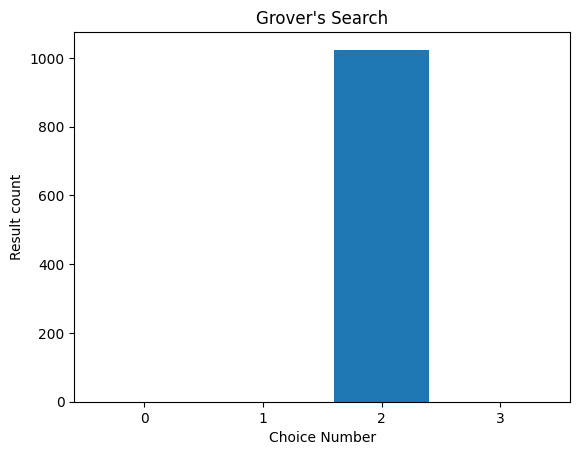

In [ ]:
"""Create the circuit for Grover's algorithm."""

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, reps = 1) # COMPLETE THIS CODE
print("Circuit for Grover's algorithm:")
print(circuit)
# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

#### **Problem #3.3**

**Independently**, visualize the results for Grover's algorithm on this problem for 0 to 3 iterations. For each number of iterations, notice the histogram. What changes do you observe? Do you see amplitude amplification? Does the right choice's amplitude get amplified?

**Using these results, answer what is the optimal number of iterations that maximizes the amplification of the right choice's amplitude?**

In [ ]:
# COMPLETE THIS CODE FOR 0 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 1 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 2 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 3 ITERATIONS

#End of notebook
---
© 2024 The Coding School, All rights reserved